In [4]:
!pip install transformers tensorflow_hub

In [54]:
import os
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel, TFAutoModel, AutoConfig
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import tensorflow_hub as hub

In [6]:
os.environ["WANDB_API_KEY"] = "0" # to silence warning


In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


In [8]:
df_train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv",engine="python")
df_train = df_train.drop(df_train[df_train.language != "English"].index)
df_train = df_train.drop(['lang_abv','language'], axis=1)
df_train.premise=df_train.premise.str.lower()
df_test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv",engine="python")
df_test = df_test.drop(df_test[df_test.language != "English"].index)
df_test = df_test.drop(['lang_abv','language'], axis=1)
df_test.premise=df_test.premise.str.lower()

In [9]:
df_train.shape # check data


(6870, 4)

In [10]:
df_test.shape # check data


(2945, 3)

In [11]:
model_name = 'google/bert_uncased_L-12_H-768_A-12'
tokenizer = BertTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [12]:
len(tokenizer.vocab) # check the vocabulary size


30522

In [13]:
def encode_sentence(s):
    """ ENCODE SENTENCES WITH TOKENIZER"""
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)


In [14]:
encode_sentence("you know they can't really defend themselves")


[2017, 2113, 2027, 2064, 1005, 1056, 2428, 6985, 3209, 102]

In [15]:
def bert_encode(hypotheses, premises, tokenizer):
    """ ENCODE DATA FOR BERT"""
    num_examples = len(hypotheses)
    print("num_examples = ", num_examples)
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    print("sentence1.shape = ", sentence1.shape)
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
    print("sentence2.shape = ", sentence2.shape)
    cls_ = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls_, sentence1, sentence2], axis=-1)
    print("input_word_ids.shape = ", input_word_ids.shape)
    # 300 - as my example
    # because we have train_input (12120; 259), test_input (5159; 234)
    # and shape[1] should be the same in each dataset
    # that is why we creating (xxx; 300) shape in to_tensor() functions  
    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(input_word_ids.shape[0], 300)) 
    print("input_mask.shape = ", input_mask.shape)
    
    type_cls = tf.zeros_like(cls_)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=(input_word_ids.shape[0], 300))
    
    inputs = {'input_word_ids': input_word_ids.to_tensor(shape=(input_word_ids.shape[0], 300)),
              'input_mask': input_mask,
              'input_type_ids': input_type_ids}
    print()
    
    return inputs

In [16]:
# encode data
print(df_test["premise"].values)
train_input = bert_encode(df_train["premise"].values, df_train["hypothesis"].values, tokenizer)
test_input = bert_encode(df_test["premise"].values, df_test["hypothesis"].values, tokenizer)


['his family had lost a son and a daughter now.'
 'steps are initiated to allow program board membership to reflect the clienteligible community and include representatives from the funding community, corporations and other partners.'
 "agencies' operating trust, enterprise and internal service funds) are required to produce auditable financial statements."
 ...
 'the  rock  has a soft texture and can be bought in a variety of shapes.'
 "isn't it i can remember i've only been here eight years but i can remember coming to work from i used to live in wylie and i could see downtown dallas"
 'in hong kong you can have a plate, or even a whole dinner service, hand-painted to your own design.']
num_examples =  6870


2022-01-13 17:40:30.920328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 17:40:30.921369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 17:40:30.922046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 17:40:30.922937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

sentence1.shape =  (6870, None)
sentence2.shape =  (6870, None)
input_word_ids.shape =  (6870, None)
input_mask.shape =  (6870, 300)

num_examples =  2945
sentence1.shape =  (2945, None)
sentence2.shape =  (2945, None)
input_word_ids.shape =  (2945, None)
input_mask.shape =  (2945, 300)



In [80]:
def create_model():
    bert_encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/2",
        trainable=True)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    embedding = bert_encoder({'input_word_ids':input_word_ids, 'input_mask': input_mask, 'input_type_ids': input_type_ids})['pooled_output']
    output4 = tf.keras.layers.Dense(3, activation='softmax')(embedding)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output4)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [81]:
max_len = train_input["input_word_ids"].shape[1]

with strategy.scope():
    model = create_model()
    model.summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
keras_layer_17 (KerasLayer)     {'pooled_output': (N 12750081    input_mask[0][0]                 
                                                                 input_type_ids[0][0]      

In [82]:
model_history = model.fit(train_input, 
                          df_train["label"].values, 
                          epochs = 50, 
                          verbose = 1,
                          batch_size = 128, 
                          validation_split = 0.2)


Epoch 1/50
43/43 [==============================] - 32s 554ms/step - loss: 1.1989 - accuracy: 0.3393 - val_loss: 1.1240 - val_accuracy: 0.3486
Epoch 2/50
43/43 [==============================] - 23s 544ms/step - loss: 1.1053 - accuracy: 0.3783 - val_loss: 1.1090 - val_accuracy: 0.3719
Epoch 3/50
43/43 [==============================] - 23s 544ms/step - loss: 1.0790 - accuracy: 0.4110 - val_loss: 1.0897 - val_accuracy: 0.3959
Epoch 4/50
43/43 [==============================] - 23s 544ms/step - loss: 1.0567 - accuracy: 0.4405 - val_loss: 1.0810 - val_accuracy: 0.4156
Epoch 5/50
43/43 [==============================] - 23s 544ms/step - loss: 1.0368 - accuracy: 0.4672 - val_loss: 1.0700 - val_accuracy: 0.4279
Epoch 6/50
43/43 [==============================] - 23s 545ms/step - loss: 1.0117 - accuracy: 0.4893 - val_loss: 1.0527 - val_accuracy: 0.4600
Epoch 7/50
43/43 [==============================] - 23s 545ms/step - loss: 0.9812 - accuracy: 0.5278 - val_loss: 1.0304 - val_accuracy: 0.4964

In [84]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()


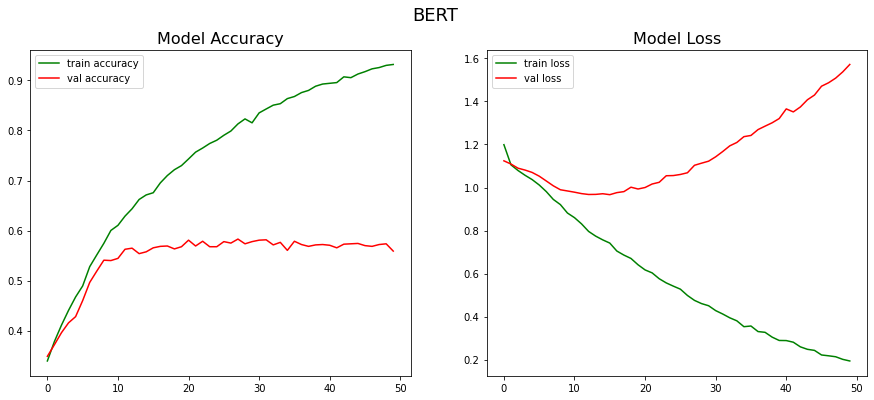

In [85]:
plot_NN_history(model_history, "BERT")


In [22]:
def calculate_results(y_true, y_pred):
    """ CALCULATE RESULTS"""
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results


In [23]:
# get the probabilities
y_prob = model.predict(test_input)
# get the classes
y_hat = y_prob.argmax(axis=-1)

print(y_hat)

[0 1 1 ... 2 0 0]


In [24]:
# submission = df_test.id.copy().to_frame()
# submission['prediction'] = y_hat
# submission.head() # check submission
# submission.to_csv("submission.csv", index = False) # save file


In [83]:
model.save('./model.h5')